#### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [1]:
import warnings
from typing import List, Tuple

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
data = pd.read_csv("data/assignment2/test.csv")

In [3]:
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
target = data["isFraud"]
data = data.drop(["TransactionID", "isFraud"], axis=1)
print("data.shape = {} rows, {} cols".format(*data.shape))

data.shape = 100001 rows, 392 cols


In [20]:
x_train, x_test = train_test_split(
    data, train_size=0.70, shuffle=False
)
y_train, y_test = train_test_split(
    target, train_size=0.70, shuffle=False
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 70000 rows, 392 cols
x_test.shape = 30001 rows, 392 cols


In [21]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 70000 rows, 378 cols
x_test.shape = 30001 rows, 378 cols


In [22]:
model = xgb.XGBClassifier(random_state=1, eval_metric='mlogloss')
model.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_test, y_test)], 
          early_stopping_rounds=50, 
          eval_metric="auc",
          verbose=50)

[0]	validation_0-auc:0.78079	validation_1-auc:0.78428
[50]	validation_0-auc:0.97366	validation_1-auc:0.89962
[80]	validation_0-auc:0.98576	validation_1-auc:0.89572


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [8]:
train_score = roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.752, Test-score: 0.685


In [9]:
train_score_proba = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
test_score_proba = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

print(f"Train-score: {round(train_score_proba, 3)}, Test-score: {round(test_score_proba, 3)}")

Train-score: 0.955, Test-score: 0.9


##### Observations: It seems like predict_proba for roc_auc_score gives us a relatively good estimation if transaction is fraud. But we validated our model only on one set of data. So it might not be as good in predicting the fraud transactions on the other set of data. We also didn't shuffle out data, and used data sorted by transaction id

#### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [10]:
x_train, x_valid = train_test_split(
    data, train_size=0.75, shuffle=False
)
y_train, y_valid = train_test_split(
    target, train_size=0.75, shuffle=False
)

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]

x_valid, x_test = train_test_split(
    x_valid, train_size=0.75, shuffle=False
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.75, shuffle=False
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 75000 rows, 378 cols
x_valid.shape = 18750 rows, 378 cols
x_test.shape = 6251 rows, 378 cols


In [11]:
model = xgb.XGBClassifier(random_state=1, eval_metric='mlogloss')
model.fit(x_train, y_train,
          eval_set=[(x_train, y_train),(x_valid, y_valid), (x_test, y_test)], 
          early_stopping_rounds=50, 
          eval_metric="auc",
          verbose=50)

[0]	validation_0-auc:0.78473	validation_1-auc:0.77029	validation_2-auc:0.80284
[50]	validation_0-auc:0.97074	validation_1-auc:0.90176	validation_2-auc:0.92089
[99]	validation_0-auc:0.98829	validation_1-auc:0.90568	validation_2-auc:0.92460


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [12]:
train_score = roc_auc_score(y_train, model.predict(x_train))
valid_score = roc_auc_score(y_valid, model.predict(x_valid))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.859, Valid-score: 0.684, Test-score: 0.711


In [13]:
train_score_proba = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
valid_score_proba = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
test_score_proba = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

print(f"Train-score: {round(train_score_proba, 3)}, Valid-score: {round(valid_score_proba, 3)}, Test-score: {round(test_score_proba, 3)}")

Train-score: 0.988, Valid-score: 0.906, Test-score: 0.925


##### Observation: By adding extra set to validate our model, we increased our test score by 2.5 %. But we still used sorted/not shuffled data, so our model might not be as good in predicting the fraud transactions on the other set of data

#### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [14]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx

In [15]:
def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores

In [16]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [17]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)

calculate_confidence_interval(scores)

(0.9078537766510067, 0.9411326895085139)

Text(0.5, 0, 'sampel number')

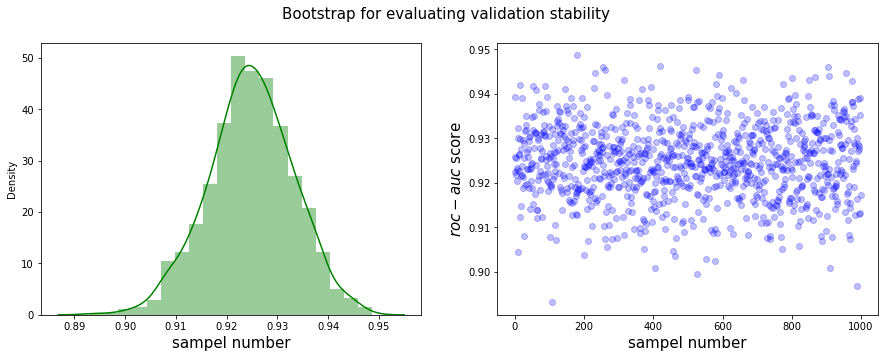

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$roc-auc$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

##### Observation: it seems like 95% results have a score between 0.908 and 0.0.941 which tells us that our prediction is stable. 

#### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

#### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [30]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [31]:
cv = cross_val_score(
    estimator=model, X=data[numerical_features], y=target, scoring="roc_auc", cv=5
)

print(cv)
print(f"CV-mean: {round(np.mean(cv), 4)}, CV-std: {round(np.std(cv), 4)}")

[0.79388494 0.87829508 0.65261536 0.64575973 0.86115091]
CV-mean: 0.7663, CV-std: 0.0998


###### Observation: CV-std: 0.0998 is big, so i don't think we can rely on this score